# The RBM flow and the Critical Temperature of Ising Models

This is the notebook for the paper X.

Firstly, we import the necessary Python packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
torch.manual_seed(12)

from MC_Ising2D import IsingMC
from net import Net
from _rbm import RBM
L = 100
Tc_Ons = 2 / ( np.log(1 + np.sqrt(2)) )
Tc_MF = 4.0

The neural network thermometer is called by the following function.

In [13]:
def thermometer(flow_,
                ising_data,
                L= 100,
                x= 0,
                step= 2,
                save= False,
                Tzero= True, 
                x_text= 0,
                y_text= 0.15,
                errorbar= True,
                publication= False,
                loc_legend= 'lower right',
                NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt'):
    
    net = Net()
    net = torch.load(NN_path)  
    
    if publication:
        plt.figure(figsize=(3.375, 0.678*3.375))
        plt.xticks(fontsize= 6)
        plt.yticks(fontsize= 6)
        markersize = 4.0
        linewidth= 0.4
        fontsize_l = 7.0
        fontsize_t = 8.0
        fontsize_lg= 5.0
        capsize= 2.0   
        elinewidth= 0.2
        markeredgewidth = 0.2
        
    else:
        markersize= 10.0
        linewidth= 0.8
        fontsize_l= 12.0
        fontsize_t= 12.0
        fontsize_lg= 10.0
        capsize= 5.0
        elinewidth= 0.5
        markeredgewidth= 0.5
       
    for j in range(0, len(flow_) - x, step):
        
        prediction = net(flow_[j])
        
        if errorbar:
                   
            plt.errorbar(np.sort(ising_data['temp'].value_counts().index),
                         prediction.cpu().mean(dim=0).data.numpy(),
                         yerr= prediction.cpu().std(dim=0).data.numpy(),
                         lolims= 0.0,
                         marker= '.',
                         markersize= markersize,
                         linewidth= linewidth,
                         capsize= capsize,
                         elinewidth= elinewidth,
                         markeredgewidth= markeredgewidth,
                         label= 'It = %d' % j )
            
        else:
            
            plt.plot(np.sort(ising_data['temp'].value_counts().index),
                     prediction.cpu().mean(dim=0).data.numpy(),
                     marker= '.',
                     markersize= markersize,
                     linewidth= linewidth,
                     label= 'It = %d' % j )
        
        
        plt.axvline(x= Tc_Ons, linestyle= ':', linewidth= 0.8, color= 'black')
        
        plt.xlabel('Temperature scale', fontsize= fontsize_l)
        plt.ylabel('Softmax probability', fontsize= fontsize_l)
        
    plt.legend(fontsize= fontsize_lg,
               loc= loc_legend)
    
    if Tzero:
        plt.text(x= x_text, y= y_text, s= '$T_0 = 0$', fontsize= fontsize_t)
    else:
        plt.text(x= x_text, y= y_text, s= '$T_0  =\infty$', fontsize= fontsize_t)
        
    plt.ylim(0.0, plt.ylim()[1])
    
    if save:
        if Tzero:
            if publication:
                path_fig = 'figures/PUB_flow_L%d_ONLY_Tin_zero.pdf' % L
                plt.savefig(path_fig , bbox_inches='tight')
            else:
                path_fig = 'figures/flow_L%d_ONLY_Tin_zero.pdf' % L
                plt.savefig(path_fig, bbox_inches='tight')
        else:
            if publication:
                path_fig = 'figures/PUB_flow_L%d_ONLY_Tin_inf.pdf' % L
                plt.savefig(path_fig , bbox_inches='tight')
            else:
                path_fig = 'figures/flow_L%d_ONLY_Tin_inf.pdf' % L
                plt.savefig(path_fig , bbox_inches='tight')
                           
    plt.show()

The magnetization can be also be analyzed during flow dynamics.

In [7]:
def magnetization(flow_low,
                  flow_high,
                  L= 100,
                  errorbar= True,
                  Tzero= True,
                  x= 0, 
                  step= 1,
                  loc_legend= 'lower right',
                  save= False, 
                  publication= False):
              
    mag_low= []
    er_bar_low= []
    x_axis= [] 
    
    for j in range(0, len(flow_low)- x, step):
        flow = 2*flow_low[j] - 1
        mag = (abs(flow.sum(1))/(L*L)).mean()
        error_bar = (abs(flow.sum(1))/(L*L)).std()
        
        mag_low.append(mag.item())
        er_bar_low.append(error_bar.item())
        x_axis.append(j)
        
    mag_high= []
    er_bar_high= []
        
 
    for j in range(0, len(flow_high)- x, step):
        flow = 2*flow_high[j] - 1
        mag = (abs(flow.sum(1))/(L*L)).mean()
        error_bar = (abs(flow.sum(1))/(L*L)).std()
        
        mag_high.append(mag.item())
        er_bar_high.append(error_bar.item())
  

    if publication:
        plt.figure(figsize=(3.375, 0.678*3.375))
        plt.xticks(fontsize= 6)
        plt.yticks(fontsize= 6)
        markersize = 4.0
        linewidth= 0.4
        fontsize_l = 7.0
        fontsize_t = 8.0
        fontsize_lg= 5.0
        capsize= 2.0   
        elinewidth= 0.2
        markeredgewidth = 0.2
        
    else:
        markersize = 10.0
        linewidth= 0.8
        fontsize_l = 12.0
        fontsize_t = 12.0
        fontsize_lg= 10.0
        capsize= 5.0
        elinewidth= 0.5
        markeredgewidth = 0.5
        
    if errorbar:
               
        plt.errorbar(x_axis,
                     mag_low,
                     yerr= er_bar_low,
                     label= '$T_{0}=0$',
                     marker= '.',
                     markersize= markersize,
                     linewidth= linewidth,
                     capsize= capsize,
                     elinewidth= elinewidth,
                     markeredgewidth= markeredgewidth)
        
        plt.errorbar(x_axis,
                     mag_high,
                     yerr= er_bar_high,
                     label= '$T_{0}  = \infty$',
                     marker= '.',
                     markersize= markersize,
                     linewidth= linewidth,
                     capsize= capsize,
                     elinewidth= elinewidth,
                     markeredgewidth= markeredgewidth)
    else:
        
        plt.plot(x_axis, 
                 mag_low,
                 label= '$T_{0}=0$',
                 marker= '.',
                 markersize= markersize,
                 linewidth= linewidth)
        
        plt.plot(x_axis, 
                 mag_high,
                 label= '$T_{0} = \infty$',
                 marker= '.',
                 markersize= markersize,
                 linewidth= linewidth)
        
    plt.xlabel('Flow iteration', fontsize= fontsize_l)
    plt.ylabel('$m$', fontsize= fontsize_l)
    
    plt.legend(fontsize= fontsize_t,
               loc= loc_legend)
    
    #plt.ylim(0.0, plt.ylim()[1])
    
    if save:
        if publication:
            path_fig = 'figures/PUB_mag_flow_L%d_ONLY.pdf' % L
            plt.savefig(path_fig , bbox_inches='tight')
        else:
            path_fig = 'figures/mag_flow_L%d_ONLY.pdf' % L
            plt.savefig(path_fig, bbox_inches='tight')
    
    plt.show()

## Scale-invariant feature extraction


### Loading Ising data

The first step is to load the Ising data generated by Monte Carlo procedure. The file `data/L100_1000sweeps.pkl` was constructed considering a square lattice $L\times L$, with $L=100$. There are 1000 spins configurations for each of 29 different temperatures $ T/J = 1, 1.1, 1.2, ..., 3.5 $ and $ T/J = 2.259, 2.269, 2.279$.

In [4]:
ising_data = pd.read_pickle('data/L100_Ising2D_MC.pkl')
ising_data.head()

,energy,magn,state,temp
0,-6656,176,"[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...",3.5
1,-6872,-248,"[1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, ...",3.5
2,-6812,544,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ...",3.5
3,-6616,-166,"[0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, ...",3.5
4,-6660,-68,"[0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...",3.5


In the thermodynamic limit $( L^2 \rightarrow \infty )$, the isotropic Ising model in a square lattice was analytically solved by [Lars Onsager](https://en.wikipedia.org/wiki/Lars_Onsager) in [1944](https://journals.aps.org/pr/abstract/10.1103/PhysRev.65.117). In this limit, the model show spontaneous magnetization for $ T < T_c$, with $T_c$ given by 

$$ \frac{T_c}{J} = \frac{2}{\log\left(1 + \sqrt{ 2}\right)} \approx 2.269185  \;. $$

The temperatures values near $ T_c$ were included in the dataset just to get a better visualization (which is a sanity check) of the Monte Carlo results for thermodynamics quantities. They are not necessary for the present discussion, as pointed out by the paper [Scale-invariant Feature Extraction of Neural Network and Renormalization Group Flow](https://arxiv.org/abs/1801.07172).

Method fit will construct states to the following temperatures: 
[3.5        3.4        3.3        3.2        3.1        3.
 2.9        2.8        2.7        2.6        2.5        2.4
 2.3        2.27918531 2.26918531 2.25918531 2.2        2.1
 2.         1.9        1.8        1.7        1.6        1.5
 1.4        1.3        1.2        1.1        1.        ]


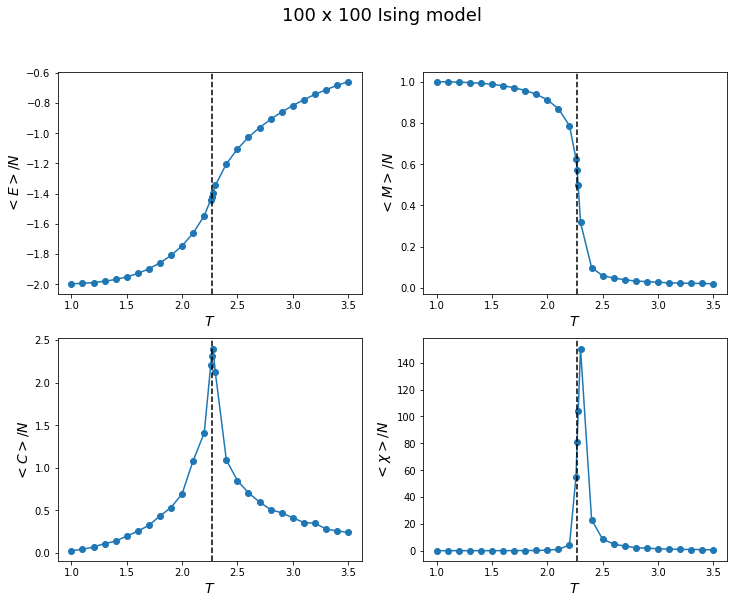

In [5]:
IsingMC(L= 100).plot_thermodynamics(spin_MC= ising_data, Tc_scaled= False)

### Flow from RBM trained with 29 different temperatures - CHANGE HERE TO $L=100$

In [ ]:
rbm = RBM()
rbm = torch.load('RBM_trained_models/RBM_model_T_complete_nv100_nh100_lr1.0E-02_k1_bsize100_nepochs8000.pt')

#### Initial temperature: $T= 0$

In [ ]:
n_states = 1000

v0 = nn.init.constant_(torch.empty(n_states, L*L),
                       val= 1.0)

In [ ]:
flow = rbm.flow(n_it_flow= 40, vk= v0)

Perhaps we will be needing this flow for further analysis, the we save it in a pickle file.

In [ ]:
with open('RBM_flows/rbm_flow_L010_ALL_Tin_zero_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [ ]:
flow_ = [ x.cuda() for x in flow ]

Temperature measurement in the defined temperature scale.

In [ ]:
thermometer(flow_,
            ising_data,
            L= 10,
            x= 15,
            step= 5,
            Tzero= True,
            x_text= 0,
            y_text= 0.15,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper right',
            NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt')

Saving the figure with the predefined pattern for publication.

In [ ]:
thermometer(flow_,
            ising_data,
            L= 10,
            x= 15,
            step= 5,
            Tzero= True,
            x_text= 0,
            y_text= 0.15,
            publication= True,
            errorbar= True,
            save= False,
            loc_legend= 'upper right',
            NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt')

#### Initial temperature: $T = \infty$

In [ ]:
L = 10
nstates = 1000

up = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 1.0)
down = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 0.0)

up_down = torch.cat((up,down), 0)

v0 = up_down.reshape(1, up_down.shape[0])

for j in range(nstates - 1):
    
    v0_ = up_down[torch.randperm(up_down.shape[0]) ]
    
    v0 = torch.cat( ( v0, v0_.reshape(1, v0_.shape[0])), 0 )

In [ ]:
flow = rbm.flow(n_it_flow= 40, vk= v0)

Perhaps we will be needing this flow for further analysis, the we save it in a pickle file.

In [ ]:
with open('RBM_flows/rbm_flow_L010_ALL_Tin_inf_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [ ]:
flow__ = [ x.cuda() for x in flow ]

Temperature measurement in the defined temperature scale.

In [ ]:
thermometer(flow__,
            ising_data,
            L= 100,
            x= 15,
            step= 5,
            Tzero= False,
            x_text= 5.0,
            y_text= 0.2,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper left',
            NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt')

Saving the figure with the predefined pattern for publication.

In [ ]:
thermometer(flow__,
            ising_data,
            L= 100,
            x= 15,
            step= 5,
            Tzero= False,
            x_text= 5.0,
            y_text= 0.2,
            publication= True,
            errorbar= True,
            save= False,
            loc_legend= 'upper left',
            NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt')

We also the dynamics of the magnetization.

In [ ]:
magnetization(flow_low= flow_,
              flow_high= flow__,
              L= 100,
              errorbar= True,
              Tzero= True,
              x = 0,
              save= False, 
              publication= False)

In [ ]:
magnetization(flow_low= flow_,
              flow_high= flow__,
              L= 100,
              errorbar= True,
              Tzero= True,
              x = 0,
              save= False, 
              publication= True)

## Flow from RBM trained only with $T=0$ and $ T = \infty$

In order to investigate the RBM flow in an extreme situation, we have trained the machine in an dataset composed only by frozen and random states. This still satisfies the condition shown in the work [Scale-invariant Feature Extraction of Neural Network and Renormalization Group Flow](https://arxiv.org/abs/1801.07172): the RBM flow would go towards the critical value if the data training set has states with temperature values less and greater than the critical one.

It is crucial to note that, since the visible layer is always fed with an unidimensional vector (an array is transformed in a vector to be fed in the visible layer), the machine does not have any geometric information about the lattice in this case.

### RBM flow

In [8]:
rbm = RBM()
rbm = torch.load('RBM_trained_models/RBM_model_T_zero_inf_nv10000_nh10000_lr1.0E-03_k1_bsize100_nepochs1000.pt')

#### Initial temperature: $T= 0$

In [7]:
n_states = 1000

v0 = nn.init.constant_(torch.empty(n_states, L*L),
                       val= 1.0)

In [8]:
flow = rbm.flow(n_it_flow= 40, vk= v0)

Perhaps we will be needing this flow for further analysis, the we save it in a pickle file.

In [20]:
with open('RBM_flows/rbm_flow_L100_ONLY_Tin_zero_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [9]:
flow_ = [ x.cuda() for x in flow ]

Temperature measurement in the defined temperature scale.

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


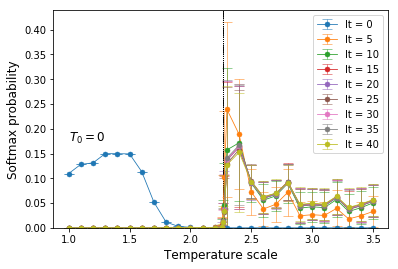

In [19]:
thermometer(flow_,
            ising_data,
            L= 100,
            x= 0,
            step= 5,
            Tzero= True,
            x_text= 1.0,
            y_text= 0.175,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper right',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

Saving the figure with the predefined pattern for publication.

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


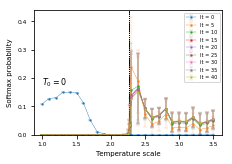

In [14]:
thermometer(flow_,
            ising_data,
            L= 100,
            x= 0,
            step= 5,
            Tzero= True,
            x_text= 1.0,
            y_text= 0.175,
            publication= True,
            errorbar= True,
            save= True,
            loc_legend= 'upper right',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

In [21]:
del flow_
torch.cuda.empty_cache()

#### Initial temperature: $T = \infty$

In [6]:
L = 100
nstates = 1000

up = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 1.0)
down = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 0.0)

up_down = torch.cat((up,down), 0)

v0 = up_down.reshape(1, up_down.shape[0])

for j in range(nstates - 1):
    
    v0_ = up_down[torch.randperm(up_down.shape[0]) ]
    
    v0 = torch.cat( ( v0, v0_.reshape(1, v0_.shape[0])), 0 )

In [9]:
flow = rbm.flow(n_it_flow= 40, vk= v0)

Perhaps we will be needing this flow for further analysis, the we save it in a pickle file.

In [16]:
with open('RBM_flows/rbm_flow_L100_ONLY_Tin_inf_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [10]:
flow__ = [ x.cuda() for x in flow ]

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


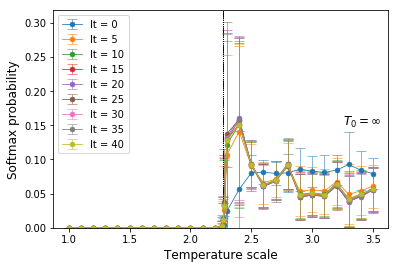

In [14]:
thermometer(flow__,
            ising_data,
            L= 100,
            x= 0,
            step= 5,
            Tzero= False,
            x_text= 3.25,
            y_text= 0.15,
            publication= False,
            errorbar= True,
            save= True,
            loc_legend= 'upper left',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

Saving the figure with the predefined pattern for publication.

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


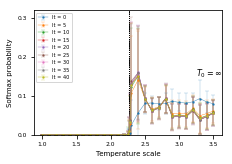

In [15]:
thermometer(flow__,
            ising_data,
            L= 100,
            x= 0,
            step= 5,
            Tzero= False,
            x_text= 3.25,
            y_text= 0.15,
            publication= True,
            errorbar= True,
            save= True,
            loc_legend= 'upper left',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

We also analyze the dynamics of the magnetization.

In [3]:
with open('RBM_flows/rbm_flow_L100_ONLY_Tin_zero_it040.pkl', 'rb') as f:
    flow= pickle.load(f)
    
flow_ = [ x.cpu() for x in flow ]

In [4]:
with open('RBM_flows/rbm_flow_L100_ONLY_Tin_inf_it040.pkl', 'rb') as f:
    flow= pickle.load(f)
    
flow__ = [ x.cpu() for x in flow ]

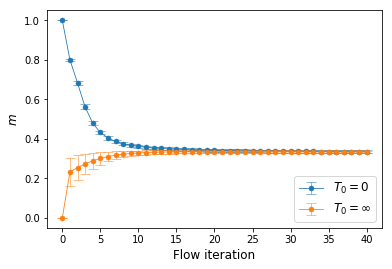

In [8]:
magnetization(flow_low= flow_,
              flow_high= flow__,
              L= 100,
              errorbar= True,
              Tzero= True,
              x = 0,
              save= True, 
              loc_legend= 'lower right',
              publication= False)

We also analyze the dynamics of the magnetization.

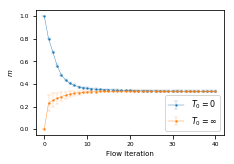

In [9]:
magnetization(flow_low= flow_,
              flow_high= flow__,
              L= 100,
              errorbar= True,
              Tzero= True,
              x = 0,
              save= True, 
              loc_legend= 'lower right',
              publication= True)